In [42]:
# Data Creation and Manipulation
import pandas as pd
import numpy as np
from pandasql import sqldf  # !pip install pandasql if needed

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Statistics
from scipy import stats

In [49]:
# Compare daily average cost per click for 2 different ad keywords

# Create data
avg, st_dev = .85, 0.1 # mean and standard deviation
keyword_1 = np.random.normal(avg, st_dev, 1000)

avg, st_dev = .95, 0.15
keyword_2 = np.random.normal(avg, st_dev, 1000)

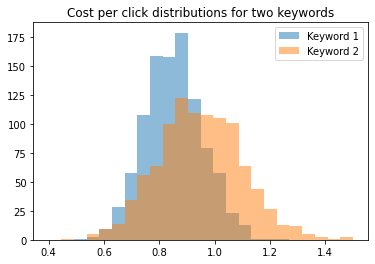

In [50]:
# Create visualization
bins = np.linspace(start=0.4, stop=1.5, num=25)

plt.hist(keyword_1, bins, alpha=0.5, label='Keyword 1')
plt.hist(keyword_2, bins, alpha=0.5, label='Keyword 2')
plt.legend(loc='upper right')
plt.title("Cost per click distributions for two keywords")
plt.show()

In [55]:
test_statistic, p_value = stats.ttest_ind(a=keyword_1, b=keyword_2, equal_var=False)

Before we actually look at the result, we need to decide on our p-value that we will use to determine whether the results are significant.

These are p-values you can use based on your sample size.

| Sample Size |
|-------------|

|  | 30 | 50 | 100 | 1000 |
|------|--------|------|------|--------|
| Weak | 0.076 | 0.053 | 0.032 | 0.009 |
| Fair | 0.028 | 0.019 | 0.010 | 0.003 |
| Strong | 0.005 | 0.003 | 0.001 | 0.0003 |
| Very Strong | 0.001 | 0.0005 | 0.0001 | 0.00004 |

In [58]:
p_value

4.4980095573753844e-55

Whoa, that's tiny!

From this, we can see that the average cost per click of the two keywords is significantly different. We might consider recommending that the less expensive keyword receive a greater amount of the budget if it also performs better in terms of conversions.

## Add-to-Carts

In [66]:
import_columns = ['event_type', 'brand', 'product_id', 'user_id', 'user_session']

df = pd.read_csv('C:/Users/ericd/Desktop/ecom-data.csv',
                 usecols=import_columns)

In [67]:
add_to_carts = len(df[df['event_type'] == "cart"])
print(f"There are {add_to_carts} add-to-cart events in the dataset.")

There are 926516 add-to-cart events in the dataset.


In [68]:
df.head()

,event_type,product_id,brand,user_id,user_session
0,view,44600062,shiseido,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,view,3900821,aqua,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,view,17200506,NaN,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,view,1307067,lenovo,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,view,1004237,apple,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


Now we can look at add-to-cart events by brand to see which brands are the most popular.

In [84]:
# Create dataframe grouping add-to-carts by brand
brand_df = ((df[df['event_type'] == "cart"]
            .groupby('brand')
            .agg(add_to_carts = pd.NamedAgg(column = 'event_type', aggfunc='count')))
            .sort_values(by=['add_to_carts'], ascending=False))

<AxesSubplot:xlabel='brand'>

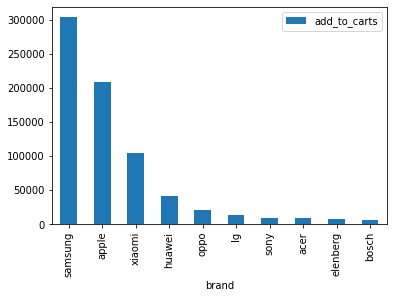

In [88]:
# Quick bar plot to see if there's anything interesting!
brand_df.head(10).plot(kind='bar')

## Conversion Rate
This is just a quick calculation. We are looking at the number of sessions where a purchase was made divided by the total number of unique sessions.

In [132]:
total_sessions = df['user_session'].nunique()
purchase_sessions = df[df['event_type'] == "purchase"]['user_session'].nunique()

conversion_rate = purchase_sessions / total_sessions

In [133]:
print(f"Conversion Rate: {round(conversion_rate*100, 1)}%")

Conversion Rate: 6.8%


## Average Order Value

In [107]:
payments_df = pd.read_csv("C:/Users/ericd/Desktop/olist_order_payments.csv", 
                          usecols=['order_id', 'payment_type', 'payment_value'])

customers_df = pd.read_csv("C:/Users/ericd/Desktop/olist_customers.csv", 
                           usecols=['customer_id', 'customer_city', 'customer_state'])

orders_df = pd.read_csv("C:/Users/ericd/Desktop/olist_orders.csv", 
                        usecols=['order_id', 'customer_id'])

In [127]:
payments_df.head(1)

,order_id,payment_type,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,credit_card,99.33


In [112]:
customers_df.head(1)

,customer_id,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,franca,SP


In [113]:
orders_df.head(1)

,order_id,customer_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d


In [118]:
# This is the "vanilla" Average Order Value (AOV)
payments_df['payment_value'].mean()

154.10038041698365

In [125]:
query = '''
        SELECT c.customer_state, AVG(p.payment_value)
        FROM payments_df p
        JOIN orders_df o
            ON o.order_id = p.order_id
        JOIN customers_df c
            ON c.customer_id = o.customer_id
        GROUP BY c.customer_state
        ORDER BY AVG(p.payment_value) DESC
'''

print(sqldf(query))

   customer_state  AVG(p.payment_value)
0              PB            248.325825
1              AC            234.293095
2              RO            233.203831
3              AP            232.325714
4              AL            227.077424
5              RR            218.796087
6              PA            215.920722
7              SE            208.438366
8              PI            207.106813
9              TO            204.270199
10             CE            199.902740
11             MA            198.856610
12             RN            196.778027
13             MT            195.228904
14             PE            187.992153
15             MS            186.867989
16             AM            181.603442
17             BA            170.816017
18             SC            165.979337
19             GO            165.763404
20             DF            161.134791
21             RJ            158.525888
22             RS            157.180406
23             ES            154.706953


In [135]:
# Adding the count of orders to the query
query = '''
        SELECT c.customer_state, AVG(p.payment_value), COUNT(p.order_id)
        FROM payments_df p
        JOIN orders_df o
            ON o.order_id = p.order_id
        JOIN customers_df c
            ON c.customer_id = o.customer_id
        GROUP BY c.customer_state
        -- ORDER BY AVG(p.payment_value) DESC
        ORDER BY COUNT(p.order_id) DESC
'''

print(sqldf(query))

   customer_state  AVG(p.payment_value)  COUNT(p.order_id)
0              SP            137.504630              43622
1              RJ            158.525888              13527
2              MG            154.706434              12102
3              RS            157.180406               5668
4              PR            154.153626               5262
5              SC            165.979337               3754
6              BA            170.816017               3610
7              DF            161.134791               2204
8              GO            165.763404               2112
9              ES            154.706953               2107
10             PE            187.992153               1728
11             CE            199.902740               1398
12             PA            215.920722               1011
13             MT            195.228904                958
14             MA            198.856610                767
15             MS            186.867989                7

In [136]:
# You can save your query results to a dataframe for further analysis
aov_df = sqldf(query)

In [137]:
aov_df

,customer_state,AVG(p.payment_value),COUNT(p.order_id)
0,SP,137.504630,43622
1,RJ,158.525888,13527
2,MG,154.706434,12102
3,RS,157.180406,5668
4,PR,154.153626,5262
5,SC,165.979337,3754
6,BA,170.816017,3610
7,DF,161.134791,2204
8,GO,165.763404,2112
9,ES,154.706953,2107
